# import and load data

In [1]:
import numpy as np
from scipy import io, signal
import matplotlib.pyplot as plt
from mimo_lib.simulate_transmission import simulate_transmission
from mimo_lib.spatial_filters import Linear, SvdFilter, DftFilter
from mimo_lib.TaskCfg import TaskCfg, load_link

In [2]:
def periodic_corr(x, y):
    return np.fft.ifft(np.fft.fft(x) * np.fft.fft(y).conj())

In [3]:
'''
y expected to be in <bs_ind> x <sc_ind> format
SNR in dB
'''
def add_noise(y, SNR):
    # average signal power over antennas
    if y.ndim == 1:
        Ps = np.var(y, ddof=1)
    else:
        print(np.var(y, axis=1, ddof=1))
        Ps = np.mean(np.var(y, axis=1, ddof=1))
    
    Dn = Ps / (10**(SNR/10))
    
    n0 = (np.random.normal(size=y.shape) + \
        1j*np.random.normal(size=y.shape))*np.sqrt(Dn/2)

    return y + n0


def gen_noise(y, SNR):
    # average signal power over antennas
    if y.ndim == 1:
        Ps = np.var(y, ddof=1)
    else:
        Ps = np.mean(np.var(y, axis=1, ddof=1))
    
    Dn = Ps / (10**(SNR/10))
    
    n0 = (np.random.normal(size=y.shape) + \
        1j*np.random.normal(size=y.shape))*np.sqrt(Dn/2)

    return n0


def noise_std(y, SNR):
    # average signal power over antennas
    if y.ndim == 1:
        Ps = np.var(y, ddof=1)
    else:
        Ps = np.mean(np.var(y, axis=1, ddof=1))
    
    Dn = Ps / (10**(SNR/10))
    
    return np.sqrt(Dn)

In [66]:
chan_name = "chan_2"
link_channel = io.loadmat("Data/link_{}.mat".format(chan_name))['Link_Channel']
# new axes: <time> x <sub-carrier> x <UE antenna> x <BS antenna>
link_channel = np.moveaxis(link_channel, [3, 2], [0, 1])
# normalization of the channel
path_loss_avg = np.mean(np.abs(link_channel))
link_channel = link_channel / (np.sqrt(2.) * path_loss_avg)   

# << loading channel data >>
# axes: <time> x <sub-carrier> x <UE antenna> x <BS antenna>
H = link_channel

# process all the svd at once to improve performance
H_u, H_s, H_vh = np.linalg.svd(H, full_matrices=False)
packet_cnt, sc_cnt, ue_ant_cnt, bs_ant_cnt = H.shape

# << loading SRS signals >> 
srs_seqs = io.loadmat('srsSeqs.mat')['srsSeqs']
srs_sc = np.arange(12, 600-12, 2)

user_ind = 0
interf_ind = 4

user_ue = 0
interf_ue = 1

srs_user = srs_seqs[user_ind]
srs_user_t = np.fft.ifft(srs_user)
srs_interf = srs_seqs[interf_ind]
srs_interf_t = np.fft.ifft(srs_interf)

# Channel frequency and impulse response

<IPython.core.display.Javascript object>


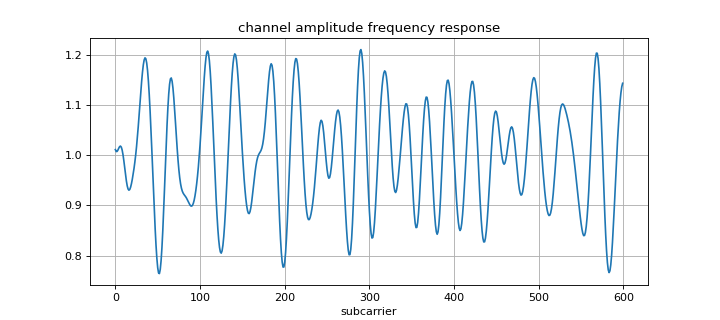

<IPython.core.display.Javascript object>


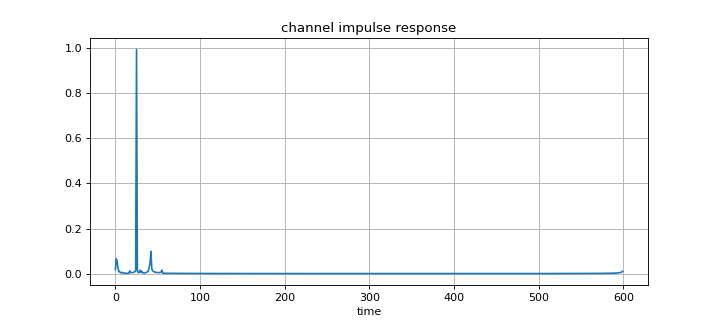

In [17]:
%matplotlib notebook

H_norm = H[0, :, user_ind, 0].copy()
H_norm /= np.mean(np.abs(H_norm))

H_norm_t = np.fft.ifft(H_norm)

# frequency responce
plt.figure(figsize=(9, 4))
plt.title("channel amplitude frequency response")
plt.xlabel('subcarrier')
plt.plot(np.abs(H_norm))
plt.grid(True)

# impulse responce
plt.figure(figsize=(9, 4))
plt.title("channel impulse response")
plt.xlabel('time')
plt.plot(np.abs(H_norm_t))
plt.grid(True)

<IPython.core.display.Javascript object>


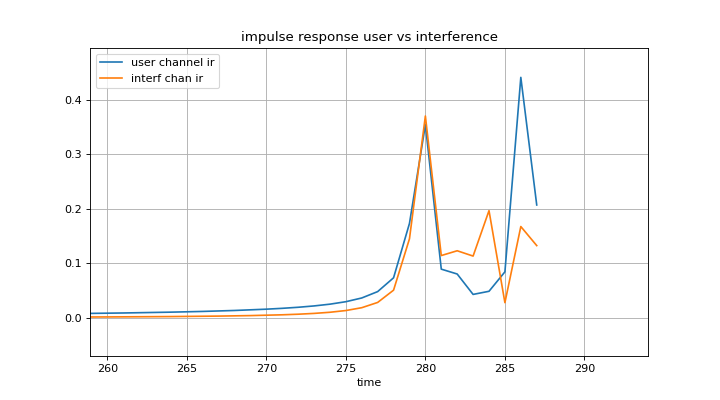

In [67]:
# let's consider impulse response of user and interference

Hh_user_00 = H[0, srs_sc, user_ue, 0].conj().T # 0 time, srs, user ue, 0 bs_ant
Hh_interf_00 = H[0, srs_sc, interf_ue, 0].conj().T # 0 time, srs, interf ue, 0 bs_ant

Hh_user_00_t = np.fft.ifft(Hh_user_00)
Hh_interf_00_t = np.fft.ifft(Hh_interf_00)

plt.figure(figsize=(9, 5))
plt.plot(np.abs(Hh_user_00_t))
plt.plot(np.abs(Hh_interf_00_t))
plt.plot(0.7*2)
plt.title("impulse response user vs interference")
plt.xlabel("time")
plt.legend(["user channel ir", "interf chan ir"])
plt.grid(True)

# Channel Estimation with SRS

In [73]:
from numba import njit

@njit
def channel_est_LS(y, srs_seq, srs_sc):
    H_LS = srs_seq.conj()*y
    return H_LS


def channel_est_LS_rect_wnd_hard(y, srs_seq, srs_sc, wnd_mid=-3, wnd_width=20):
    H_LS = srs_seq.conj()*y
    H_LS_t = np.fft.ifft(H_LS)
    
    wnd_st = (wnd_mid-wnd_width//2)%y.shape[0]
    wnd_end = (wnd_st + wnd_width)%y.shape[0]
    
    if wnd_st <= wnd_end:
        wnd = np.zeros(y.shape, dtype=np.complex128)
        wnd[wnd_st:wnd_end] = 1.
    else:
        wnd = np.ones(y.shape, dtype=np.complex128)
        wnd[wnd_end: wnd_st] = 0.
    
    if wnd_width >= y.shape[0]:
        wnd = np.ones(y.shape[0], dtype=np.complex128)
        
    H_LS_wnd_t = wnd * H_LS_t
    H_LS_wnd = np.fft.fft(H_LS_wnd_t)
    
    return H_LS_wnd


def channel_est_LS_wnd_SNR(y, srs_seq, srs_sc, snr):
    H_LS = srs_seq.conj()*y
    H_LS_t = np.fft.ifft(H_LS)
    
    Ps_est = (y@y.conj()).real/y.shape[0]
    
    # divide by N cause ifft 
    Pn = (Ps_est * 10**(-0.1*snr))/y.shape[0]
    n_sigma = np.sqrt(Pn)
    
    window = np.ones(y.shape, dtype=np.complex128)
    
    window[np.abs(H_LS_t) < 3 * n_sigma] = 0.5
    window[np.abs(H_LS_t) < 2 * n_sigma] = 0.1
    window[np.abs(H_LS_t) < n_sigma] = 0
    
    window[13:265] = 0 # chan_1: [0:246], chan_2: [13:265], chan_PATH: [15:270] # TODO: add wnd mid parameter
    
    H_LS_wnd_t = window * H_LS_t
    H_LS_wnd = np.fft.fft(H_LS_wnd_t)
    
    return H_LS_wnd, n_sigma


def channel_est_LS_wnd_STD(y, srs_seq, srs_sc, n_sigma, s3_coef=0.5, s2_coef=0.1):
    H_LS = srs_seq.conj()*y
    H_LS_t = np.fft.ifft(H_LS)
    
    # divide cause ifft
    n_sigma /= np.sqrt(y.shape[0])
    
    window = np.ones(y.shape, dtype=np.complex128)
    
    window[np.abs(H_LS_t) < 3 * n_sigma] = 0.5
    window[np.abs(H_LS_t) < 2 * n_sigma] = 0.1
    window[np.abs(H_LS_t) < n_sigma] = 0
    
    window[13:265] = 0
    
    H_LS_wnd_t = window * H_LS_t
    H_LS_wnd = np.fft.fft(H_LS_wnd_t)
    
    return H_LS_wnd


def channel_est_LS_wnd_STD2(y, srs_seq, srs_sc, n_sigma, cut_off=3, noise_cut_off=2):
    H_LS = srs_seq.conj()*y
    H_LS_t = np.fft.ifft(H_LS)
    
    # divide cause ifft
    n_sigma /= np.sqrt(y.shape[0])
    
    window = np.ones(y.shape, dtype=np.complex128)
    
    Ps_est = np.maximum(0, np.abs(H_LS_t)**2 - noise_cut_off*n_sigma**2)
    window = np.minimum(np.sqrt(Ps_est)/n_sigma, cut_off)
    
    window[13:265] = 0
    window/=np.max(window)
    
    H_LS_wnd_t = window * H_LS_t
    H_LS_wnd = np.fft.fft(H_LS_wnd_t)
    
    return H_LS_wnd

# LS estimation

In [33]:
def corr_coef(X, Y):
    return np.correlate(X, Y)/np.sqrt(np.correlate(X, X)*np.correlate(Y, Y))

<IPython.core.display.Javascript object>


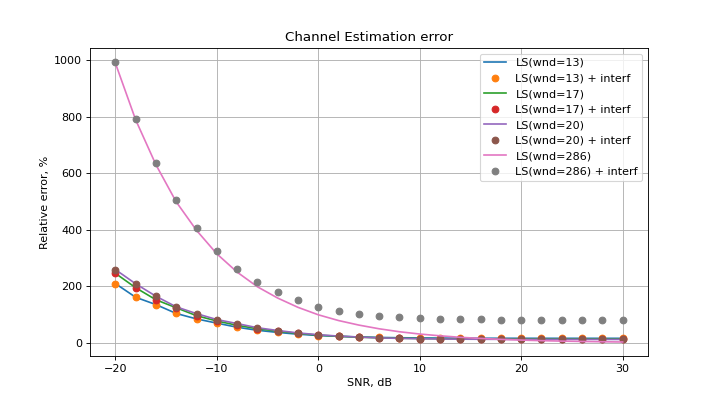

<IPython.core.display.Javascript object>


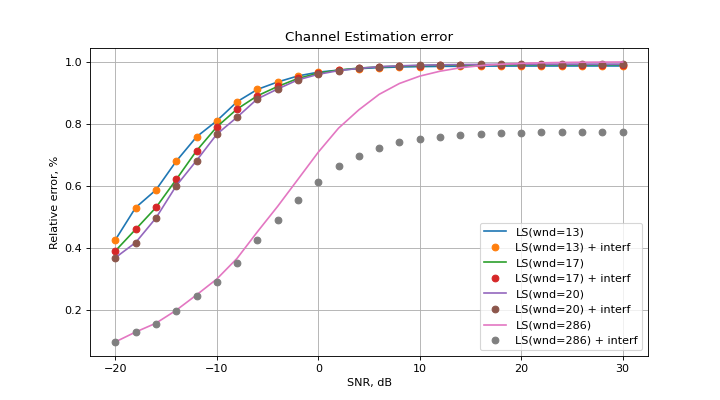

In [82]:
%matplotlib notebook

Hh_user_00 = H[0, srs_sc, user_ue, 0].conj().T # 0 time, srs, user ue, 0 bs_ant
Hh_interf_00 = H[0, srs_sc, interf_ue, 0].conj().T # 0 time, srs, interf ue, 0 bs_ant

y = srs_user * Hh_user_00
y_interf = srs_interf * Hh_interf_00


snr_list = np.arange(-20, 31, 2)
wnd_width_list = [13, 17, 20, 286]
attempt_cnt = 100    # number of attempts for result averaging

err_LS = dict()
err_LS_interf = dict()

corr_LS = dict()
corr_LS_interf = dict()

for wnd_width in wnd_width_list:
    err_LS[wnd_width] = np.zeros(len(snr_list), dtype=np.complex128)
    err_LS_interf[wnd_width] = np.zeros(len(snr_list), dtype=np.complex128)
    
    corr_LS[wnd_width] = np.zeros(len(snr_list), dtype=np.complex128)
    corr_LS_interf[wnd_width] = np.zeros(len(snr_list), dtype=np.complex128)
    
    for snr_ind, snr in enumerate(snr_list):
        for q in range(attempt_cnt):
            yn = add_noise(y, snr)
            yni = yn + y_interf

            H_LS = channel_est_LS_rect_wnd_hard(yn, srs_user, srs_sc, wnd_mid=-5, wnd_width=wnd_width)
            H_LS_interf = channel_est_LS_rect_wnd_hard(yni, srs_user, srs_sc, wnd_mid=-5, wnd_width=wnd_width)

            err_LS[wnd_width][snr_ind] += np.linalg.norm(Hh_user_00 - H_LS) / np.linalg.norm(Hh_user_00)
            err_LS_interf[wnd_width][snr_ind] += np.linalg.norm(Hh_user_00 - H_LS_interf) / np.linalg.norm(Hh_user_00)
            
            corr_LS[wnd_width][snr_ind] += corr_coef(Hh_user_00, H_LS)
            corr_LS_interf[wnd_width][snr_ind] += corr_coef(Hh_user_00, H_LS_interf)

        err_LS[wnd_width][snr_ind] /= attempt_cnt
        err_LS_interf[wnd_width][snr_ind] /= attempt_cnt
        
        corr_LS[wnd_width][snr_ind] /= attempt_cnt
        corr_LS_interf[wnd_width][snr_ind] /= attempt_cnt

# plotting results
plt.figure(figsize=(9, 5))

legend = []
for wnd_width in wnd_width_list:
    plt.plot(snr_list, np.abs(err_LS[wnd_width]) * 100, '-')
    plt.plot(snr_list, np.abs(err_LS_interf[wnd_width]) * 100, 'o')
    
    legend += ['LS(wnd={})'.format(wnd_width)]
    legend += ['LS(wnd={}) + interf'.format(wnd_width)]

plt.legend(legend)

plt.xlabel("SNR, dB")
plt.ylabel("Relative error, %")
plt.title("Channel Estimation error")
plt.grid(True)

# plotting correlation
plt.figure(figsize=(9, 5))

legend = []
for wnd_width in wnd_width_list:
    plt.plot(snr_list, np.abs(corr_LS[wnd_width]), '-')
    plt.plot(snr_list, np.abs(corr_LS_interf[wnd_width]), 'o')
    
    legend += ['LS(wnd={})'.format(wnd_width)]
    legend += ['LS(wnd={}) + interf'.format(wnd_width)]

plt.legend(legend)

plt.xlabel("SNR, dB")
plt.ylabel("Relative error, %")
plt.title("Channel Estimation error")
plt.grid(True)

C:\Users\sasha\AppData\Local\Temp/ipykernel_9556/3031372880.py:90: RuntimeWarning: invalid value encountered in true_divide
  window/=np.max(window)


<IPython.core.display.Javascript object>


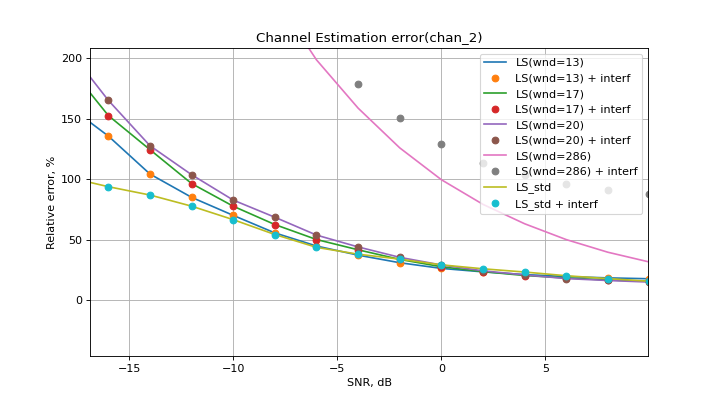

<IPython.core.display.Javascript object>


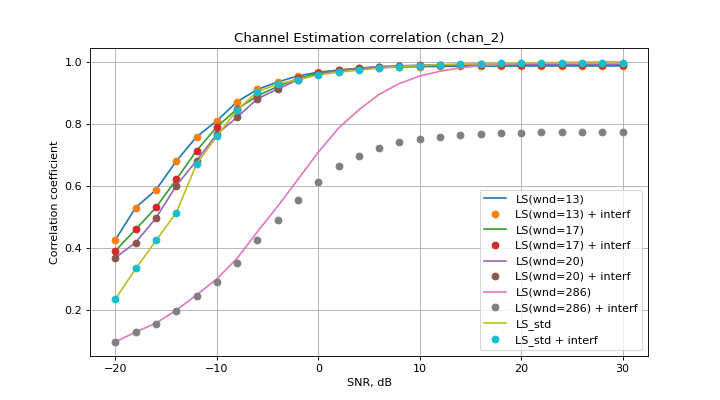

In [83]:
%matplotlib notebook


err_LS_std = np.zeros(len(snr_list), dtype=np.complex128)
err_LS_std_interf = np.zeros(len(snr_list), dtype=np.complex128)

corr_LS_std = np.zeros(len(snr_list), dtype=np.complex128)
corr_LS_std_interf = np.zeros(len(snr_list), dtype=np.complex128)

err_LS_std2 = np.zeros(len(snr_list), dtype=np.complex128)
err_LS_std2_interf = np.zeros(len(snr_list), dtype=np.complex128)

for snr_ind, snr in enumerate(snr_list):
    for q in range(attempt_cnt):
        yn = add_noise(y, snr)
        yni = yn + y_interf
        n_std = noise_std(y, snr)
        
        s3_coef = 0.8
        s2_coef = 0.0
        H_LS_std = channel_est_LS_wnd_STD(yn, srs_user, srs_sc, n_std, s3_coef, s2_coef)
        H_LS_std_interf = channel_est_LS_wnd_STD(yni, srs_user, srs_sc, n_std, s3_coef, s2_coef)

        err_LS_std[snr_ind] += np.linalg.norm(Hh_user_00 - H_LS_std) / np.linalg.norm(Hh_user_00)
        err_LS_std_interf[snr_ind] += np.linalg.norm(Hh_user_00 - H_LS_std_interf) / np.linalg.norm(Hh_user_00)
        
        corr_LS_std[snr_ind] += corr_coef(Hh_user_00, H_LS_std)
        corr_LS_std_interf[snr_ind] += corr_coef(Hh_user_00, H_LS_std_interf)
        
        cut_off=3
        noise_cut_off=2.5
        H_LS_std2 = channel_est_LS_wnd_STD2(yn, srs_user, srs_sc, n_std, cut_off, noise_cut_off)
        H_LS_std2_interf = channel_est_LS_wnd_STD2(yni, srs_user, srs_sc, n_std, cut_off, noise_cut_off)

        err_LS_std2[snr_ind] += np.linalg.norm(Hh_user_00 - H_LS_std2) / np.linalg.norm(Hh_user_00)
        err_LS_std2_interf[snr_ind] += np.linalg.norm(Hh_user_00 - H_LS_std2_interf) / np.linalg.norm(Hh_user_00)
        
    err_LS_std[snr_ind] /= attempt_cnt
    err_LS_std_interf[snr_ind] /= attempt_cnt
    
    corr_LS_std[snr_ind] /= attempt_cnt
    corr_LS_std_interf[snr_ind] /= attempt_cnt
    
    err_LS_std2[snr_ind] /= attempt_cnt
    err_LS_std2_interf[snr_ind] /= attempt_cnt
    
plt.figure(figsize=(9, 5))

legend = []
for wnd_width in wnd_width_list:
    plt.plot(snr_list, np.abs(err_LS[wnd_width]) * 100, '-')
    plt.plot(snr_list, np.abs(err_LS_interf[wnd_width]) * 100, 'o')
    
    legend += ['LS(wnd={})'.format(wnd_width)]
    legend += ['LS(wnd={}) + interf'.format(wnd_width)]

plt.plot(snr_list, np.abs(err_LS_std*100), '-')
plt.plot(snr_list, np.abs(err_LS_std_interf*100), 'o')
legend += ['LS_std', 'LS_std + interf']

#plt.plot(snr_list, np.abs(err_LS_std2*100), '-')
#plt.plot(snr_list, np.abs(err_LS_std2_interf*100), 'o')
#legend += ['LS_std2', 'LS_std2 + interf']

plt.legend(legend)

plt.xlabel("SNR, dB")
plt.ylabel("Relative error, %")
plt.title("Channel Estimation error({})".format(chan_name))
plt.grid(True)


# plot correlation
plt.figure(figsize=(9, 5))

legend = []
for wnd_width in wnd_width_list:
    plt.plot(snr_list, np.abs(corr_LS[wnd_width]), '-')
    plt.plot(snr_list, np.abs(corr_LS_interf[wnd_width]), 'o')
    
    legend += ['LS(wnd={})'.format(wnd_width)]
    legend += ['LS(wnd={}) + interf'.format(wnd_width)]

plt.plot(snr_list, np.abs(corr_LS_std), '-')
plt.plot(snr_list, np.abs(corr_LS_std_interf), 'o')
legend += ['LS_std', 'LS_std + interf']

plt.legend(legend)

plt.xlabel("SNR, dB")
plt.ylabel("Correlation coefficient")
plt.title("Channel Estimation correlation ({})".format(chan_name))
plt.grid(True)

# BER simulation

In [75]:
def estimate_H_mat(y, srs_seq, srs_sc, estim_func, estim_args):
    # y should be <bs> x <sc>
    H_est = np.zeros(y.shape, dtype=np.complex128)
    for row in range(y.shape[0]):
        H_est[row] = estim_func(y[row], srs_seq, srs_sc, *estim_args)
    
    return H_est

In [80]:
from mimo_lib.hard_detection import hard_detection

snr_list = np.arange(-20, 10, 2)
attempt_cnt = 50

#Hh_user_0 = H[0, srs_sc, user_ue, :].conj().T # 0 time, <srs>, user ue, <all bs_ant>
#Hh_interf_0 = H[0, srs_sc, interf_ue, :].conj().T # 0 time, <srs>, interf ue, <all bs_ant>
#
## dim: <bs> x <sc>
#y = srs_user * Hh_user_0
#yi = srs_interf * Hh_interf_0


Hh_est_names = ['ideal',
                'LS', 'LS + interf', 
                'LS_wnd_hard(13)', 'LS_wnd_hard(13) + interf', 
                'LS_wnd_hard(17)', 'LS_wnd_hard(17) + interf', 
                'LS_wnd_std', 'LS_wnd_std + interf']#, 
                #'LS_wnd_std2', 'LS_wnd_std2 + interf']

ber = np.zeros((len(Hh_est_names), snr_list.shape[0]))

for snr_ind, snr in enumerate(snr_list):
    for attempt_ind in range(attempt_cnt):
        Hh_user_0 = H[attempt_ind, srs_sc, user_ue, :].conj().T # 0 time, <srs>, user ue, <all bs_ant>
        Hh_interf_0 = H[attempt_ind, srs_sc, interf_ue, :].conj().T # 0 time, <srs>, interf ue, <all bs_ant>
        
        y = srs_user * Hh_user_0
        yi = srs_interf * Hh_interf_0
        
        noise = gen_noise(y, snr)
        yn = y + noise
        yni = yn + yi
        n_std = noise_std(y, snr)
        
        Hh_estimates = []
        
        #ideal estimation
        Hh_estimates.append(Hh_user_0)
        # just LS
        Hh_estimates.append(estimate_H_mat(yn, srs_user, srs_sc, channel_est_LS, []))
        Hh_estimates.append(estimate_H_mat(yni, srs_user, srs_sc, channel_est_LS, []))
        #hard(10)
        Hh_estimates.append(estimate_H_mat(yn, srs_user, srs_sc, channel_est_LS_rect_wnd_hard, [-5, 13]))
        Hh_estimates.append(estimate_H_mat(yni, srs_user, srs_sc, channel_est_LS_rect_wnd_hard, [-5, 13]))
        #hard(30)
        Hh_estimates.append(estimate_H_mat(yn, srs_user, srs_sc, channel_est_LS_rect_wnd_hard, [-5, 17]))
        Hh_estimates.append(estimate_H_mat(yni, srs_user, srs_sc, channel_est_LS_rect_wnd_hard, [-5, 17]))
        #std
        Hh_estimates.append(estimate_H_mat(yn, srs_user, srs_sc, channel_est_LS_wnd_STD, [n_std, 0.8, 0.0]))
        Hh_estimates.append(estimate_H_mat(yni, srs_user, srs_sc, channel_est_LS_wnd_STD, [n_std, 0.8, 0.0]))
        #std2
        #Hh_estimates.append(estimate_H_mat(yn, srs_user, srs_sc, channel_est_LS_wnd_STD2, [n_std, 3, 1]))
        #Hh_estimates.append(estimate_H_mat(yni, srs_user, srs_sc, channel_est_LS_wnd_STD2, [n_std, 3, 1]))
        
                            
        # simulate transmission
        iq_tx = (2 * np.random.randint(0, 2, srs_sc.shape) - 1)
        
        # precode->propagate->decode
        for est_ind, Hh_est in enumerate(Hh_estimates):
            iq_rx = np.zeros(iq_tx.shape, dtype=np.complex128)
            iq_rx_by_ant = np.zeros((64, 288), dtype=np.complex128)
            for sc_ind in range(Hh_est.shape[1]):
                Hu, Hs, Hvh = np.linalg.svd(Hh_est[:,sc_ind].reshape((-1, 1)))
                # lets take first singular vector as precoder
                prec = Hvh[0].conj()
                dec = Hu[:, 0].conj()
                
                iq_rx_by_ant = (Hh_user_0[:, sc_ind] * (iq_tx[sc_ind] * prec)) + noise[:, sc_ind]
                iq_rx[sc_ind] = dec @ iq_rx_by_ant
            
            iq_rx = hard_detection(iq_rx, "BPSK")
            ber[est_ind, snr_ind] += np.mean(np.abs(iq_rx-iq_tx)/2)/attempt_cnt
            
    
    print('SNR = {}:'.format(snr))
    for est_ind in range(ber.shape[0]):
        print("\t{}: ber={:.3f}".format(Hh_est_names[est_ind], ber[est_ind, snr_ind]))
        
        

SNR = -20:
	ideal: ber=0.136
	LS: ber=0.493
	LS + interf: ber=0.494
	LS_wnd_hard(13): ber=0.424
	LS_wnd_hard(13) + interf: ber=0.424
	LS_wnd_hard(17): ber=0.443
	LS_wnd_hard(17) + interf: ber=0.443
	LS_wnd_std: ber=0.447
	LS_wnd_std + interf: ber=0.446
SNR = -18:
	ideal: ber=0.091
	LS: ber=0.494
	LS + interf: ber=0.495
	LS_wnd_hard(13): ber=0.382
	LS_wnd_hard(13) + interf: ber=0.382
	LS_wnd_hard(17): ber=0.415
	LS_wnd_hard(17) + interf: ber=0.415
	LS_wnd_std: ber=0.399
	LS_wnd_std + interf: ber=0.398
SNR = -16:
	ideal: ber=0.044
	LS: ber=0.492
	LS + interf: ber=0.495
	LS_wnd_hard(13): ber=0.301
	LS_wnd_hard(13) + interf: ber=0.301
	LS_wnd_hard(17): ber=0.352
	LS_wnd_hard(17) + interf: ber=0.352
	LS_wnd_std: ber=0.292
	LS_wnd_std + interf: ber=0.291
SNR = -14:
	ideal: ber=0.019
	LS: ber=0.480
	LS + interf: ber=0.482
	LS_wnd_hard(13): ber=0.202
	LS_wnd_hard(13) + interf: ber=0.202
	LS_wnd_hard(17): ber=0.257
	LS_wnd_hard(17) + interf: ber=0.257
	LS_wnd_std: ber=0.160
	LS_wnd_std + interf

<IPython.core.display.Javascript object>


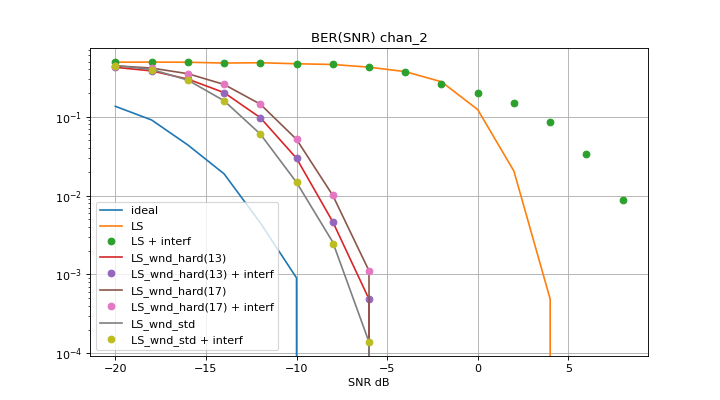

Text(0, 0.5, '')

In [81]:
%matplotlib notebook

fig = plt.figure(figsize=(9,5))
for est_ind in range(ber.shape[0]):
    fmt = '-'
    if est_ind%2==0 and est_ind != 0:
        fmt = 'o'
    plt.plot(snr_list, ber[est_ind], fmt)

plt.grid(True)
plt.legend(Hh_est_names)
plt.yscale('log')
plt.xlabel("SNR dB")
plt.title("BER(SNR) {}".format(chan_name))
plt.ylabel("")